In [12]:
import sklearn
import json
from PIL import Image
from torch.utils.data import Dataset
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as f
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile

Harrison_datapath = '/content/drive/MyDrive/Computer Vision Project/val.zip'

# Unzip training data
zip_ref = zipfile.ZipFile(Harrison_datapath, 'r')
zip_ref.extractall('/content/data')
zip_ref.close()

In [10]:
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Computer Vision Project/train.zip', 'r')
zip_ref.extractall('/content/data')
zip_ref.close()

In [4]:
detector_classes = ['Rhesus_macaque', 'Olive_baboon', 'Gibbon', 'Golden_lion_tamarin', 'Common_marmoset', 'Bonobo', 'Siamang', 'Crab-eating_macaque', 'Vervet_monkey', 'Orangutan', 'Gorilla', 'Chacma_baboon', 'Chimpanzee', 'Golden_snub-nosed_monkey', 'Hamadryas_baboon', 'Cotton-top_tamarin', 'Proboscis_monkey', 'Barbary_macaque', 'Dusky_leaf_monkey', 'Squirrel_monkey', 'Emperor_tamarin', 'Tufted_capuchin', 'Mandrill', 'Lion-tailed_macaque', 'Formosan_rock_macaque', 'Japanese_macaque']

In [5]:
class MonkeyDetectionDataSet(torch.utils.data.Dataset):
    
    def __init__(self, anotation_url, data_path, classes, transform):
        with open(anotation_url) as f:
            train_annotations = json.load(f)
        
        boxes = []
        im_name = []
        train_labels = []
        class_dict = {}
        for data in train_annotations['data']:
            species = data['species']
            boxes.append(data['bbox'])
            if species not in class_dict.keys():
                class_dict[species] = 0
            class_dict[species] += 1
            train_labels.append(species)
            im_name.append(data['file'])
            
        label_to_id = {}
        for i, species in enumerate(classes):
            label_to_id[species] = i
            
        labels = [label_to_id[label] for label in train_labels]
        
        transformed_boxes = []
        for box in boxes:
            transformed_box = [box[0], box[1], box[0] + box[2], box[1] + box[3]]
            transformed_boxes.append(transformed_box)
        self.boxes = transformed_boxes
        self.labels = labels
        self.inputs = im_name
        self.data_path = data_path
        
        self.transform = transform
        
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, index):
        
        im_uri = self.inputs[index]
        box = self.boxes[index]
        label = self.labels[index]
        
        im = Image.open(self.data_path + im_uri)
        inputs = self.transform(im)
        
        target = {'boxes': torch.tensor([box]), 'labels': torch.tensor([label])}
        
        return {'x': inputs, 'y':target}

In [6]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights

transform = FasterRCNN_ResNet50_FPN_Weights.DEFAULT.transforms()

cuda = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def load_detector(pth_path, num_classes, cuda):
  detector = fasterrcnn_resnet50_fpn()
  in_features = detector.roi_heads.box_predictor.cls_score.in_features
  detector.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
  detector = detector.to(cuda)
  detector.load_state_dict(torch.load(pth_path))
  return detector

In [7]:
anotaion_url = '/content/drive/MyDrive/Computer Vision Project/val_annotation.json'
data_path = '/content/data/val/'


val_dataset = MonkeyDetectionDataSet(anotaion_url, data_path, detector_classes, transform)

In [8]:

def colate_monkey(batch):
  inputs = [data['x'] for data in batch]
  labels = [data['y'] for data in batch]
  return inputs, labels
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=colate_monkey)


In [13]:
def visualize_confusion_matrix(confusion, accuracy, label_classes, name):
    plt.title("{}, accuracy = {:.3f}".format(name, accuracy))
    plt.imshow(confusion)
    # plt.axis('off')
    ax, fig = plt.gca(), plt.gcf()
    plt.xticks(np.arange(len(label_classes)), label_classes)
    plt.yticks(np.arange(len(label_classes)), label_classes)
    ax.set_xticks(np.arange(len(label_classes) + 1) - .5, minor=True)
    ax.set_yticks(np.arange(len(label_classes) + 1) - .5, minor=True)
    ax.tick_params(which="minor", bottom=False, left=False)
    plt.show()

In [11]:
with open('/content/drive/MyDrive/Computer Vision Project/train_annotation.json') as f:
  train_annotations = json.load(f)

class_dict = {}
for data in train_annotations['data']:
    species = data['species']
    if species not in class_dict.keys():
        class_dict[species] = 0
    class_dict[species] += 1

class_dict

{'Japanese_macaque': 29424,
 'Rhesus_macaque': 9347,
 'Olive_baboon': 988,
 'Gibbon': 1061,
 'Golden_lion_tamarin': 1061,
 'Common_marmoset': 741,
 'Bonobo': 755,
 'Siamang': 960,
 'Crab-eating_macaque': 2807,
 'Vervet_monkey': 1865,
 'Orangutan': 1490,
 'Gorilla': 1326,
 'Chacma_baboon': 1407,
 'Chimpanzee': 4631,
 'Golden_snub-nosed_monkey': 122,
 'Hamadryas_baboon': 1515,
 'Cotton-top_tamarin': 1071,
 'Proboscis_monkey': 1135,
 'Barbary_macaque': 1622,
 'Dusky_leaf_monkey': 84,
 'Squirrel_monkey': 277,
 'Emperor_tamarin': 780,
 'Tufted_capuchin': 63,
 'Mandrill': 1080,
 'Lion-tailed_macaque': 1114,
 'Formosan_rock_macaque': 191}

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

0.7752622612749933
Missed 766 images
[0, 19, 56, 59, 68, 71, 90, 224, 248, 300, 301, 303, 306, 365, 374, 399, 405, 412, 526, 532, 535, 567, 574, 584, 586, 706, 738, 761, 798, 819, 820, 837, 869, 872, 899, 908, 985, 1004, 1012, 1039, 1058, 1182, 1223, 1231, 1252, 1296, 1302, 1333, 1382, 1447, 1461, 1471, 1534, 1567, 1618, 1633, 1648, 1689, 1698, 1745, 1763, 1767, 1804, 1814, 1885, 1915, 1921, 1954, 1972, 2002, 2008, 2021, 2048, 2067, 2103, 2194, 2197, 2238, 2267, 2289, 2297, 2345, 2364, 2462, 2549, 2566, 2600, 2605, 2682, 2711, 2737, 2739, 2769, 2777, 2802, 2819, 2896, 2899, 2934, 2971, 3001, 3043, 3055, 3154, 3194, 3321, 3342, 3369, 3375, 3403, 3477, 3525, 3534, 3538, 3550, 3591, 3627, 3644, 3690, 3703, 3729, 3760, 3776, 3826, 3880, 3890, 3919, 3930, 3988, 4015, 4094, 4107, 4138, 4157, 4158, 4185, 4258, 4287, 4304, 4313, 4356, 4358, 4368, 4372, 4401, 4412, 4431, 4435, 4456, 4461, 4463, 4470, 4473, 4500, 4524, 4548, 4569, 4618, 4634, 4639, 4770, 4792, 4795, 4888, 4899, 4930, 4931, 4951,

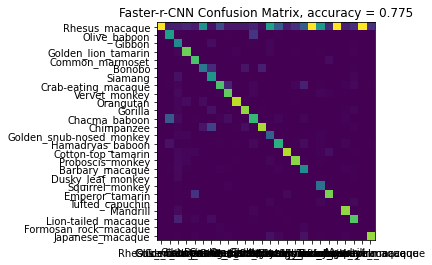

In [14]:
v1_dec = load_detector('/content/drive/MyDrive/Computer Vision Project/detector.pth',len(detector_classes),cuda)

correct = 0
total = 0
missed = []
v1_dec.eval()
confusion = np.zeros((len(detector_classes),len(detector_classes)))
with torch.no_grad():
  for i, (input, label) in enumerate(val_dataloader):
    input = [input[0].to(cuda)]
    pred = v1_dec(input)
    boxes = pred[0]['boxes'].detach().cpu().numpy()
    lables = pred[0]['labels'].detach().cpu().numpy()
    scores = pred[0]['scores'].detach().cpu().numpy()
    if len(boxes) > 0:
      best_label = lables[np.argmax(scores)]
    else:
      best_label = np.random.randint(len(detector_classes))
      missed.append(i)
    if(best_label == label[0]['labels'].item()):
      correct += 1
    total += 1
    confusion[label[0]['labels'].item(), best_label] += 1

for i in range(len(detector_classes)):
  confusion[:,i] = confusion[:,i] / np.sum(confusion[:,i])
accuracy = correct / total
print(accuracy)
print(f'Missed {len(missed)} images')
print(missed)
visualize_confusion_matrix(confusion, accuracy, detector_classes, 'Faster-r-CNN Confusion Matrix')


In [ ]:
v2_dec = load_detector('/content/drive/MyDrive/Computer Vision Project/detector_v2.pth',len(detector_classes),cuda)

correct = 0
total = 0
missed = []
v2_dec.eval()
with torch.no_grad():
  for i, (input, label) in enumerate(val_dataloader):
    input = [input[0].to(cuda)]
    pred = v2_dec(input)
    boxes = pred[0]['boxes'].detach().cpu().numpy()
    lables = pred[0]['labels'].detach().cpu().numpy()
    scores = pred[0]['scores'].detach().cpu().numpy()
    if len(boxes) > 0:
      best_label = lables[np.argmax(scores)]
    else:
      best_label = np.random.randint(len(detector_classes))
      missed.append(i)
    if(best_label == label[0]['labels'].item()):
      correct += 1
    total += 1
print(correct / total)
print(f'Missed {len(missed)} images')
print(missed)

0.797274275979557
Missed 1271 images
[0, 12, 19, 56, 59, 68, 71, 90, 224, 248, 262, 300, 301, 303, 306, 322, 365, 374, 399, 405, 412, 473, 475, 490, 501, 526, 532, 535, 540, 561, 567, 574, 583, 584, 586, 648, 706, 711, 738, 761, 798, 819, 820, 829, 837, 869, 872, 899, 901, 908, 911, 964, 972, 985, 1004, 1012, 1039, 1058, 1059, 1077, 1078, 1096, 1172, 1182, 1192, 1223, 1231, 1245, 1247, 1252, 1258, 1296, 1302, 1309, 1328, 1333, 1337, 1352, 1382, 1429, 1447, 1461, 1467, 1471, 1534, 1545, 1567, 1598, 1618, 1633, 1644, 1658, 1689, 1698, 1734, 1745, 1763, 1767, 1778, 1804, 1814, 1848, 1885, 1915, 1921, 1924, 1936, 1954, 1972, 1986, 2002, 2008, 2021, 2048, 2052, 2067, 2079, 2103, 2127, 2194, 2197, 2238, 2289, 2297, 2345, 2364, 2382, 2401, 2461, 2462, 2467, 2487, 2530, 2538, 2543, 2549, 2566, 2600, 2605, 2626, 2649, 2682, 2711, 2737, 2739, 2741, 2769, 2777, 2783, 2802, 2803, 2819, 2838, 2896, 2899, 2934, 2936, 2938, 2971, 3021, 3030, 3041, 3043, 3055, 3131, 3132, 3150, 3154, 3165, 3194, 3221,